# Part 1

In [1]:
import os
import numpy as np
from scipy import integrate, linalg
from matplotlib import pyplot as plt

%matplotlib inline

In [2]:
mainfoil = np.genfromtxt('MainFoil_N=100.csv', delimiter =',')
flapfoil = np.genfromtxt('FlapFoil_N=100.csv', delimiter =',')

In [3]:
# rearrange panel ends data
main_x_ends, main_y_ends = mainfoil[:,0], mainfoil[:,1]
flap_x_ends, flap_y_ends = flapfoil[:,0], flapfoil[:,1]

N = np.size(main_x_ends)

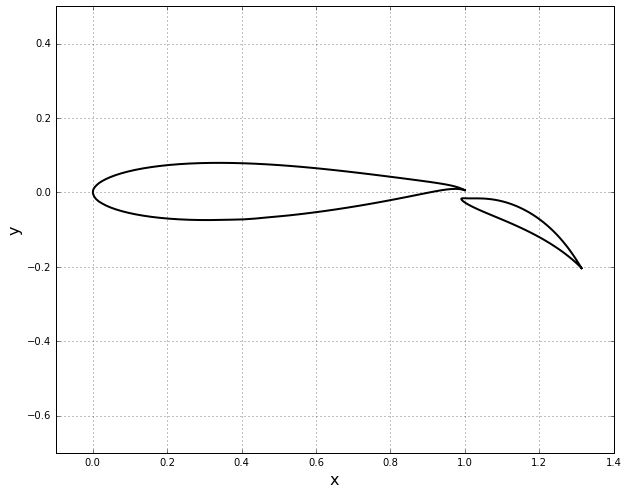

In [4]:
# plot geometry
width = 10
plt.figure(figsize=(width, width))
plt.grid()
plt.xlabel('x', fontsize=16)
plt.ylabel('y', fontsize=16)
plt.plot(main_x_ends,main_y_ends, color='k', linestyle='-', linewidth=2)
plt.plot(flap_x_ends,flap_y_ends, color='k', linestyle='-', linewidth=2)
plt.axis('scaled', adjustable='box')
plt.xlim(-0.1, 1.4)
plt.ylim(-0.7, 0.5);

In [5]:
class Panel:
    """
    Contains information related to a panel.
    """
    def __init__(self, xa, ya, xb, yb):
        """
        Initializes the panel.
        
        Sets the end-points and calculates the center-point, length,
        and angle (with the x-axis) of the panel.
        Defines if the panel is located on the upper or lower surface of the geometry.
        Initializes the source-strength, tangential velocity, and pressure coefficient
        of the panel to zero.
        
        Parameters
        ---------_
        xa: float
            x-coordinate of the first end-point.
        ya: float
            y-coordinate of the first end-point.
        xb: float
            x-coordinate of the second end-point.
        yb: float
            y-coordinate of the second end-point.
        """
        self.xa, self.ya = xa, ya # panel starting-point
        self.xb, self.yb = xb, yb # panel ending-point
        
        self.xc, self.yc = (xa+xb)/2, (ya+yb)/2         # panel center
        self.length = np.sqrt((xb-xa)**2+(yb-ya)**2) # panel length
        
        # orientation of panel (angle btw x-axis and panel's normal)
        if xb-xa <= 0.0:
            self.beta = np.arccos((yb-ya)/self.length)
        elif xb-xa > 0.0:
            self.beta = np.pi + np.arccos(-(yb-ya)/self.length)
        
        # panel location
        if self.beta <= np.pi:
            self.loc = 'upper' # upper surface
        else:
            self.loc = 'lower' # lower surface
        
        self.sigma = 0.0 # source strength
        self.vt = 0.0    # tangential velocity
        self.cp = 0.0    # pressure coefficient

In [6]:
# create panels
panels_main = np.empty(N-1, dtype = object)
panels_flap = np.empty(N-1, dtype = object)
for i in range(N-1):
    panels_main[i] = Panel(main_x_ends[i], main_y_ends[i], main_x_ends[i+1], main_y_ends[i+1])
    panels_flap[i] = Panel(flap_x_ends[i], flap_y_ends[i], flap_x_ends[i+1], flap_y_ends[i+1])

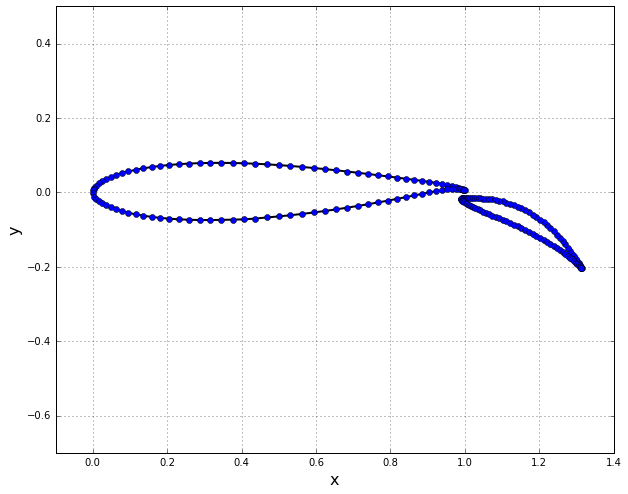

In [7]:
# plot discretized geometry
width = 10
plt.figure(figsize=(width, width))
plt.grid()
plt.xlabel('x', fontsize=16)
plt.ylabel('y', fontsize=16)
plt.plot(main_x_ends,main_y_ends, color='k', linestyle='-', linewidth=2)
plt.plot(flap_x_ends,flap_y_ends, color='k', linestyle='-', linewidth=2)
for i in range(N-1): 
    plt.plot(panels_main[i].xa, panels_main[i].ya, color = 'b', 
                    marker= 'o', markersize = 6)
    plt.plot(panels_flap[i].xa, panels_flap[i].ya, color = 'b', 
                    marker= 'o', markersize = 6)
plt.axis('scaled', adjustable='box')
plt.xlim(-0.1, 1.4)
plt.ylim(-0.7, 0.5);

In [8]:
class Freestream:
    """
    Freestream conditions.
    """
    def __init__(self, u_inf=1.0, alpha=0.0):
        """
        Sets the freestream speed and angle (in degrees).
        
        Parameters
        ----------
        u_inf: float, optional
            Freestream speed;
            default: 1.0.
        alpha: float, optional
            Angle of attack in degrees;
            default 0.0.
        """
        self.u_inf = u_inf
        self.alpha = alpha*np.pi/180.0 # degrees to radians

In [9]:
# define freestream conditions 
freestream = Freestream(u_inf=1.0, alpha = 0.0)

In [10]:
def integral(x, y, panel, dxdk, dydk):
    """
    Evaluates the contribution from a panel at a given point.
    
    Parameters
    ----------
    x: float
        x-coordinate of the target point.
    y: float
        y-coordinate of the target point.
    panel: Panel object
        Panel whose contribution is evaluated.
    dxdk: float
        Value of the derivative of x in a certain direction.
    dydk: float
        Value of the derivative of y in a certain direction.
    
    Returns
    -------
    Contribution from the panel at a given point (x, y).
    """
    def integrand(s):
        return ( ((x - (panel.xa - np.sin(panel.beta)*s))*dxdk
                  +(y - (panel.ya + np.cos(panel.beta)*s))*dydk)
                / ((x - (panel.xa - np.sin(panel.beta)*s))**2
                   +(y - (panel.ya + np.cos(panel.beta)*s))**2) )
    return integrate.quad(integrand, 0.0, panel.length)[0]

In [11]:
def source_contribution_normal(panels):
    """
    Builds the source contribution matrix for the normal velocity.
    
    Parameters
    ----------
    panels: 1D array of Panel objects
        List of panels.
    
    Returns
    -------
    A: 2D Numpy array of floats
        Source contribution matrix.
    """
    A = np.empty((panels.size, panels.size), dtype=float)
    # source contribution on a panel from itself
    np.fill_diagonal(A, 0.5)
    # source contribution on a panel from others
    for i, panel_i in enumerate(panels):
        for j, panel_j in enumerate(panels):
            if i != j:
                A[i, j] = 0.5/np.pi*integral(panel_i.xc, panel_i.yc, 
                                                panel_j,
                                                np.cos(panel_i.beta),
                                                np.sin(panel_i.beta))
    return A

In [12]:
def vortex_contribution_normal(panels):
    """
    Builds the vortex contribution matrix for the normal velocity.
    
    Parameters
    ----------
    panels: 1D array of Panel objects
        List of panels.
    
    Returns
    -------
    A: 2D Numpy array of floats
        Vortex contribution matrix.
    """
    A = np.empty((panels.size, panels.size), dtype=float)
    # vortex contribution on a panel from itself
    np.fill_diagonal(A, 0.0)
    # vortex contribution on a panel from others
    for i, panel_i in enumerate(panels):
        for j, panel_j in enumerate(panels):
            if i != j:
                A[i, j] = -0.5/np.pi*integral(panel_i.xc, panel_i.yc, 
                                                 panel_j,
                                                 np.sin(panel_i.beta),
                                                 -np.cos(panel_i.beta))
    return A

In [13]:
# combine two parts of panels
panels = np.empty(2*N-2, dtype = object)
for i in range(N-1):
    panels[i]=panels_main[i]
    panels[N+i-1]=panels_flap[i]

NameError: name 'A_source' is not defined

In [14]:
A_source = source_contribution_normal(panels)
B_vortex = vortex_contribution_normal(panels)

In [15]:
def kutta_condition(A_source, B_vortex):
    """
    Builds the Kutta condition array.
    
    Parameters
    ----------
    A_source: 2D Numpy array of floats
        Source contribution matrix for the normal velocity.
    B_vortex: 2D Numpy array of floats
        Vortex contribution matrix for the normal velocity.
    
    Returns
    -------
    b: Numpy array of floats
        The left-hand side of the Kutta-condition equation.
    """
    b = np.empty([2,A_source.shape[1]+2], dtype=float)
    # matrix of source contribution on tangential velocity
    # is the same than
    # matrix of vortex contribution on normal velocity
    b[0,:-2] = B_vortex[0, :] + B_vortex[N-2, :]
    b[1,:-2] = B_vortex[N-1, :] + B_vortex[2*N-3, :]
    # matrix of vortex contribution on tangential velocity
    # is the opposite of
    # matrix of source contribution on normal velocity
    b[-2, -2] = - np.sum(A_source[0,:N-1] + A_source[N-2,:N-1])
    b[-2, -1] = - np.sum(A_source[0,N-1:] + A_source[N-2,N-1:])
    b[-1, -2] = - np.sum(A_source[N-1,:N-1] + A_source[2*N-3,:N-1])
    b[-1, -1] = - np.sum(A_source[N-1,N-1:] + A_source[2*N-3,N-1:])
    return b

In [24]:
def build_singularity_matrix(A_source, B_vortex):
    """
    Builds the left-hand side matrix of the system
    arising from source and vortex contributions.
    
    Parameters
    ----------
    A_source: 2D Numpy array of floats
        Source contribution matrix for the normal velocity.
    B_vortex: 2D Numpy array of floats
        Vortex contribution matrix for the normal velocity.
    
    Returns
    -------
    A:  2D Numpy array of floats
        Matrix of the linear system.
    """
    A = np.empty((A_source.shape[0]+2, A_source.shape[0]+2), dtype=float)
    # source contribution matrix
    A[:-2, :-2] = A_source
    # vortex contribution array
    A[:-2, -2] = np.sum(B_vortex[:,:N-1], axis=1)  
    A[:-2, -1] = np.sum(B_vortex[:,N-1:], axis=1)
    # Kutta condition array
    A[-2:, :] = kutta_condition(A_source, B_vortex)
    return A

In [27]:
def build_freestream_rhs(panels, freestream):
    """
    Builds the right-hand side of the system 
    arising from the freestream contribution.
    
    Parameters
    ----------
    panels: 1D array of Panel objects
        List of panels.
    freestream: Freestream object
        Freestream conditions.
    
    Returns
    -------
    b: 1D Numpy array of floats
        Freestream contribution on each panel and on the Kutta condition.
    """
    b = np.empty(panels.size+2,dtype=float)
    # freestream contribution on each panel
    for i, panel in enumerate(panels):
        b[i] = -freestream.u_inf * np.cos(freestream.alpha - panel.beta)
    # freestream contribution on the Kutta condition
    b[-2] = -freestream.u_inf * (np.sin(freestream.alpha-panels[0].beta)
                              + np.sin(freestream.alpha-panels[N-2].beta) )
    b[-1] = -freestream.u_inf * (np.sin(freestream.alpha-panels[N-1].beta)
                              + np.sin(freestream.alpha-panels[2*N-3].beta) )
    return b

In [28]:
A = build_singularity_matrix(A_source, B_vortex)
b = build_freestream_rhs(panels, freestream)

In [29]:
# solve for singularity strengths
strengths = np.linalg.solve(A, b)

# store source strength on each panel
for i , panel in enumerate(panels):
    panel.sigma = strengths[i]
    
# store circulation density
gamma_main = strengths[-2]
gamma_flap = strengths[-1]

In [30]:
def compute_tangential_velocity(panels, freestream, gamma_main, gamma_flap, A_source, B_vortex):
    """
    Computes the tangential surface velocity.
    
    Parameters
    ----------
    panels: 1D array of Panel objects
        List of panels.
    freestream: Freestream object
        Freestream conditions.
    gamma_main: float
        Circulation density.
    gamma_flap: float
        Circulation density.
    A_source: 2D Numpy array of floats
        Source contribution matrix for the normal velocity.
    B_vortex: 2D Numpy array of floats
        Vortex contribution matrix for the normal velocity.
    """
    A = np.empty((panels.size, panels.size+2), dtype=float)
    # matrix of source contribution on tangential velocity
    # is the same than
    # matrix of vortex contribution on normal velocity
    A[:, :-2] = B_vortex
    # matrix of vortex contribution on tangential velocity
    # is the opposite of
    # matrix of source contribution on normal velocity
    A[:, -2] = -np.sum(A_source[:,:N-1], axis=1)
    A[:, -1] = -np.sum(A_source[:,N-1:], axis=1)
    # freestream contribution
    b = freestream.u_inf * np.sin([freestream.alpha-panel.beta 
                                    for panel in panels])
    
    strengths = np.append([panel.sigma for panel in panels], gamma_main)
    strengths = np.append(strengths,gamma_flap)
    
    tangential_velocities = np.dot(A, strengths) + b
    
    for i, panel in enumerate(panels):
        panel.vt = tangential_velocities[i]

In [31]:
compute_tangential_velocity(panels, freestream, gamma_main, gamma_flap, A_source, B_vortex)


In [32]:
for panel in panels:
        panel.cp = 1.0 - (panel.vt/freestream.u_inf)**2

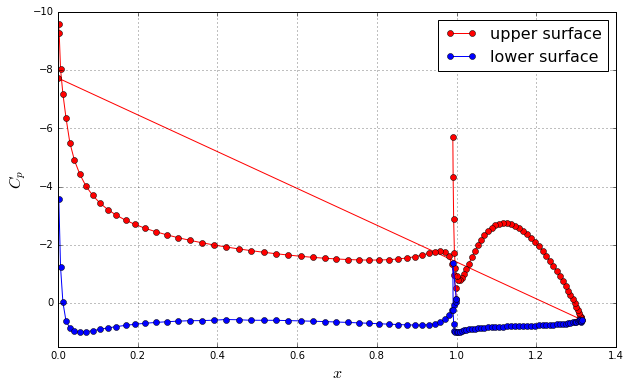

In [39]:
plt.figure(figsize=(10, 6))
plt.grid()
plt.xlabel('$x$', fontsize=16)
plt.ylabel('$C_p$', fontsize=16)
plt.plot([panel.xc for panel in panels if panel.loc == 'upper'],
            [panel.cp for panel in panels if panel.loc == 'upper'],
            label='upper surface', color='r', linestyle='-', linewidth=1, marker='o', markersize=6)
plt.plot([panel.xc for panel in panels if panel.loc == 'lower'],
            [panel.cp for panel in panels if panel.loc == 'lower'],
            label= 'lower surface',color='b', linestyle='-', linewidth=1, marker='o', markersize=6)
plt.legend(loc='best', prop={'size':16})
plt.xlim(-0, 1.4)
plt.ylim(-10, 1.5)
plt.gca().invert_yaxis()

## Questions

 The pressure coefficient on the 3rd panel on the main airfoil is

In [40]:
panels[2].cp

-0.95570117298077895

The pressure coefficient on the 10th panel on the flap airfoil is

In [41]:
panels[109].cp

-0.27991839836855581

In [42]:
lift,drag=0,0
for panel in panels:
    lift -= panel.cp*np.sin(panel.beta)*panel.length
    drag += panel.cp*np.cos(panel.beta)*panel.length

The value of lift is

In [43]:
lift

3.6977144768607491

The value of drag is

In [44]:
drag

0.010791403245870792

In [45]:
lift_theoretical=3.7386
abe=abs(lift-lift_theoretical)

The absolute error in the value of lift is

In [46]:
abe

0.040885523139250868

Then I run the same code with 200 panels on each airfoil. I get the new absolute error is 0.0201660913188. Therefore, I get the absolute error improved for about 50%.